In [1]:
# %load notebook_setup.py
#Use %load notebook_setup.py to load these commands at the top of your
#ipython notebook.  Includes running the std_libraries.py file. 

%run std_libraries.py
%load_ext autoreload
%autoreload 2
# %matplotlib 
# plt.ioff()
%matplotlib inline
#%matplotlib notebook

what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's desktop, d = othera
home directory is C:\Users\BMH_work\
y1000plus_tools dir is C:\Users\BMH_work\github\y1000plus_tools\
y1000plus data dir is C:\Users\BMH_work\github\y1000plus_tools\genomes\y1000plus\
Added C:\Users\BMH_work\github\y1000plus_tools\ to path
Added C:\Users\BMH_work\github\yeast_esr_expression_analysis\ to path
Importing y1000plus_tools.py
home directory is unset
y1000plus_tools dir is unset
y1000plus data dir is unset
Importing yeast_esr_exp.  If autoreload, may need to reset base_dir and data_processing dir 
  yeast_esr_exp.base_dir=base_dir 
 yeast_esr_exp.data_processing_dir = data_processing_dir
sys.path : 

['C:\\Users\\BMH_work\\github\\y1000plus_tools\\scripts', 'C:\\Users\\BMH_work\\Anaconda3\\envs\\y1000_plus_env\\python37.zip', 'C:\\Users\\BMH_work\\Anaconda3\\envs\\y1000_plus_env\\DLLs', 'C:\\Users\\BMH_work\\Anaconda3\\envs\\y1000_plus_env\\lib', 'C:\\Users\\BMH_work\\Anaconda3\\envs\\y1

In [2]:
def occupancy_find_filter(prom_msa_array, occ_thresh, min_len, max_gap):
    #input is multiple sequence alignment MSA, output is filtered occupancy list
    
    occupancy = []
    N_seqs = len(prom_msa_array[:,1])
    for jj,col in enumerate(prom_msa_array.T):
        occupancy.append(1.0 - Counter(col)[b'-']/N_seqs)

    occupancy = np.array(occupancy)

    #Find where occupancy is greater than thresh

    occ_ind = (occupancy>occ_thresh).astype(int)


    occ_ind_shift = occ_ind[0:-1]+occ_ind[1:]
    occ_ind_args = np.nonzero(occ_ind_shift==1)[0]

    occ_blocks = []
    L = len(occ_ind_args)

    if occ_ind[0]==0:    #starts with non-conserved block

        for jj in range(0,int(np.floor(L/2))): 
            occ_blocks.append((occ_ind_args[2*jj]+1, occ_ind_args[2*jj+1]))

        if np.mod(L,2)==1:  #ends with conserved block
            occ_blocks.append((occ_ind_args[-1]+1, len(occ_ind)-1))

    else:   #starts with conserved block
        occ_blocks.append((0,occ_ind_args[0])) #add initial block

        for jj in range(0,int(np.floor((L-1)/2))): 
            occ_blocks.append((occ_ind_args[2*jj+1]+1, occ_ind_args[2*jj+2]))

        if np.mod(L,2)==0: #ends with a conserved block
            occ_blocks.append((occ_ind_args[-1]+1, len(occ_ind)-1))


    #merge groups that are close enough together
    occ_blocks_merged = []

    block = occ_blocks.pop(0)
    if len(occ_blocks)==0: #single block 
        occ_blocks_merged.append(block)
    else: 
        while len(occ_blocks)>0: 
            next_block = occ_blocks[0]
            L_between = next_block[0]-block[1]-1
            if L_between <= max_gap: #extend block
                next_block = occ_blocks.pop(0)
                block = (block[0], next_block[1])
            else: #store block and get next block
                occ_blocks_merged.append(block)
                block = occ_blocks.pop(0)

        #store the last block
        occ_blocks_merged.append(block)

    occ_blocks_merged


    #filter groups that are not long enough

    blocks_to_keep = []

    for block in occ_blocks_merged: 
        if block[1]-block[0] > min_len: 
            blocks_to_keep.append(block)

    return blocks_to_keep

In [4]:
def read_fimo_data(block_name_list, prom_msa_array, fimo_fname_base):
    
    motif_dfs = {}
    
    for block_name in block_name_list: 
        fimo_out_fname = fimo_fname_base + 'fimo_' + block_name + '.tsv'
        #build dataframe of motif hits
        motif_table = pd.read_table(fimo_out_fname, engine= 'python', skipfooter=4)


        motifs = list(set(motif_table['motif_alt_id']))
        seq_ids = list(range(0,len(prom_msa_array))) #list(set(motif_table['sequence_name']))
        motif_array = {seq_id: {motif: 0 for motif in motifs} for seq_id in seq_ids}

        for seq_id in seq_ids: 
            for motif in motifs: 
                N_hits = len(motif_table[(motif_table['sequence_name']==seq_id) & (motif_table['motif_alt_id']==motif)])
                if N_hits>0:
                    motif_array[seq_id][motif] = N_hits

        motif_df = pd.DataFrame.from_dict(motif_array).T

        motif_dfs[block_name] = motif_df
    
    return motif_dfs

In [5]:
def find_motifs_in_blocks(blocks_to_keep, prom_msa, motif_max_pval, fimo_fname_base, fimo_fname_base_ubuntu, motif_fname):
    #Builds small fastas for each block, then calls fimo on them
    
    
    block_name_list = []

    for block in blocks_to_keep: 
        #block = blocks_to_keep[13]
        block_name = str(block[0]) + '_' + str(block[1])
        block_name_list.append(block_name)
        print(block_name)

        #Build fasta for block
        fimo_fname_fasta = fimo_fname_base + 'block_' + block_name + '.fasta'
        with open(fimo_fname_fasta + '','w') as f_fasta:
            for jj, seq in enumerate(prom_msa[:,block[0]:block[1]]):
                seq_str = str(seq.seq)
                seq_str_clean = ''.join([base for base in seq_str if base!='-'])
                if len(seq_str_clean)>0:
                    f_fasta.write('>'+str(jj) + '\n')
                    f_fasta.write(seq_str_clean + '\n')
    

        #Find motifs in each conserved block using fimo
        fimo_call = ['/home/heineike/meme/bin/fimo -oc', 
                     fimo_fname_base_ubuntu + 'fimo',          #_block_' + str(block[0]) + '_' + str(block[1]), 
                     #'--qv-thresh --thresh ', str(motif_max_qval),
                     '--thresh',str(motif_max_pval), 
                     motif_fname,
                     fimo_fname_base_ubuntu + 'block_' + block_name + '.fasta'
                    ]

        sub_out = subprocess.call('bash.exe -c "' + ' '.join(fimo_call) + '"')

        assert sub_out==0, 'Fimo call unsuccessful, ' + ' '.join(fimo_call) 
        
        #copy .tsv file to home directory, remove extra files
        fimo_out_fname = fimo_fname_base + 'fimo_' + block_name + '.tsv'
        shutil.move(fimo_fname_base + 'fimo/fimo.tsv', fimo_out_fname)
        shutil.rmtree(fimo_fname_base + 'fimo')
    
    print('fasta files and fimo run on blocks, saved in ' + fimo_fname_base)

    return block_name_list
        

## Pairwise similarity



In [3]:
aligner = Align.PairwiseAligner()
#https://biopython.readthedocs.io/en/latest/chapter_align.html#pairwisealigner

#Using default parameters from Emboss Needle 
aligner.open_gap_score = -8  #-10
aligner.extend_gap_score = -0.5

#These were from the DNAfull matrix: http://rosalind.info/glossary/dnafull/
aligner.match_score = 5
aligner.mismatch_score = -2  #-4

 

print(aligner)
print(aligner.algorithm)

#The score wasn't the same for this and with EMBOSS Needle, possibly because Gotoh algorithm was used
#It picks the aligner automatically - I am not sure why Gotoh was picked over Needleman Wuncsch

Pairwise sequence aligner with parameters
  match_score: 5.000000
  mismatch_score: -2.000000
  target_internal_open_gap_score: -8.000000
  target_internal_extend_gap_score: -0.500000
  target_left_open_gap_score: -8.000000
  target_left_extend_gap_score: -0.500000
  target_right_open_gap_score: -8.000000
  target_right_extend_gap_score: -0.500000
  query_internal_open_gap_score: -8.000000
  query_internal_extend_gap_score: -0.500000
  query_left_open_gap_score: -8.000000
  query_left_extend_gap_score: -0.500000
  query_right_open_gap_score: -8.000000
  query_right_extend_gap_score: -0.500000
  mode: global

Gotoh global alignment algorithm


In [6]:
#Load Fastas

goi_pair = 'EGO4_EGO2'
goi_alignments = {'EGO4_EGO2': 'OG6958_OG10444_OG38595_EGO4_EGO2', 
                  'GPM2_GPM3': 'OG6005_GPM2_GPM3'}

prom_fname = y1000plus_dir + os.path.normpath('promoter_sets/OG6958_OG10444_OG38595_EGO4_EGO2.fasta')
#prom_fname = y1000plus_dir + os.path.normpath('promoter_sets/OG6005_GPM2_GPM3.fasta')

prom_seqs = SeqIO.parse(prom_fname, "fasta")  

prom_seqs_list = list(prom_seqs)

#Build spec_gene list for all promoters

spec_gene_lookup = {}
spec_gene_list = []
for jj, prom_seq in enumerate(prom_seqs_list): 
    spec = prom_seq.description.split(' ')[0].split('=')[1]
    gene = prom_seq.description.split(' ')[2].split('=')[1]
    spec_gene = spec + '_' + gene
    spec_gene_list.append(spec_gene)
    spec_gene_lookup[spec_gene] = jj

#Do all by all pairwise alignment, extract a score and 
    



In [7]:
alignment_scores = {}
alignment_N_optimal = {}
ovflw = np.log10(9223372036854775807)

for gene_1_name in spec_gene_list:
    print(gene_1_name)
    #gene_1_name = 'yHAB132_kazachstania_martiniae_160519_Seq_325' #'saccharomyces_paradoxus_Seq_2332' #'saccharomyces_arboricola_Seq_2087'#'saccharomyces_paradoxus_Seq_2332'
    alignment_scores_gene_1 = []
    alignment_N_optimal_gene_1 = []
    
    gene_1 = prom_seqs_list[spec_gene_lookup[gene_1_name]]
    gene_1_L = int(gene_1.description.split(' ')[-1].split('=')[1])
    if gene_1_L != 700: 
        print('Warning: ' + gene_1_name + ' not equal to 700. L=' + str(gene_1_L))
    
    
    for gene_2_name in spec_gene_list:
        #gene_2_name = 'saccharomyces_cerevisiae_YNR034W-A'

        gene_2 = prom_seqs_list[spec_gene_lookup[gene_2_name]]
        gene_2_L = int(gene_2.description.split(' ')[-1].split('=')[1])
        
        if gene_2_L != 700: 
            print('Warning: ' + gene_2_name + ' not equal to 700. L=' + str(gene_2_L))
        alignments = aligner.align(gene_1.seq, gene_2.seq)
        alignment_scores_gene_1.append(alignments.score)
        try: 
            alignment_N_optimal_gene_1.append(np.log10(len(alignments)))
        except OverflowError:
            alignment_N_optimal_gene_1.append(ovflw)
            
        #print(np.log10(len(alignments)))
    alignment_scores[gene_1_name] = alignment_scores_gene_1
    alignment_N_optimal[gene_1_name] = alignment_N_optimal_gene_1
    
alignment_scores_df = pd.DataFrame.from_dict(alignment_scores, orient='index', columns=spec_gene_list)
alignment_N_optimal_df = pd.DataFrame.from_dict(alignment_N_optimal, orient='index', columns=spec_gene_list)

yHAB132_kazachstania_martiniae_160519_Seq_2564
yHAB132_kazachstania_martiniae_160519_Seq_325
naumovozyma_castellii_Seq_246
naumovozyma_castellii_Seq_2431
naumovozyma_castellii_Seq_527
hanseniaspora_valbyensis_Seq_301
yHMPu5000034866_zygosaccharomyces_bisporus_160519_Seq_4549
nakaseomyces_bracarensis_Seq_3421
nakaseomyces_bracarensis_Seq_2058
tetrapisispora_phaffii_Seq_1438
yHMPu5000034957_hanseniaspora_osmophila_160519_Seq_4092
lachancea_lanzarotensis_Seq_3474
eremothecium_sinecaudum_Seq_4061
lachancea_thermotolerans_Seq_718
vanderwaltozyma_polyspora_Seq_2530
torulaspora_delbrueckii_Seq_4299
saccharomyces_paradoxus_Seq_2332
saccharomyces_paradoxus_Seq_2952
eremothecium_cymbalariae_Seq_3945
yHMPu5000034865_zygosaccharomyces_kombuchaensis_160519_Seq_1422
lachancea_kluyveri_Seq_3656
lachancea_cidri_Seq_1184
yHMPu5000026152_torulaspora_franciscae_160519_Seq_5035
yHAB153_kazachstania_rosinii_160519_Seq_1089
eremothecium_gossypii_Seq_1412
yHMPu5000035695_hanseniaspora_pseudoguilliermondii_16

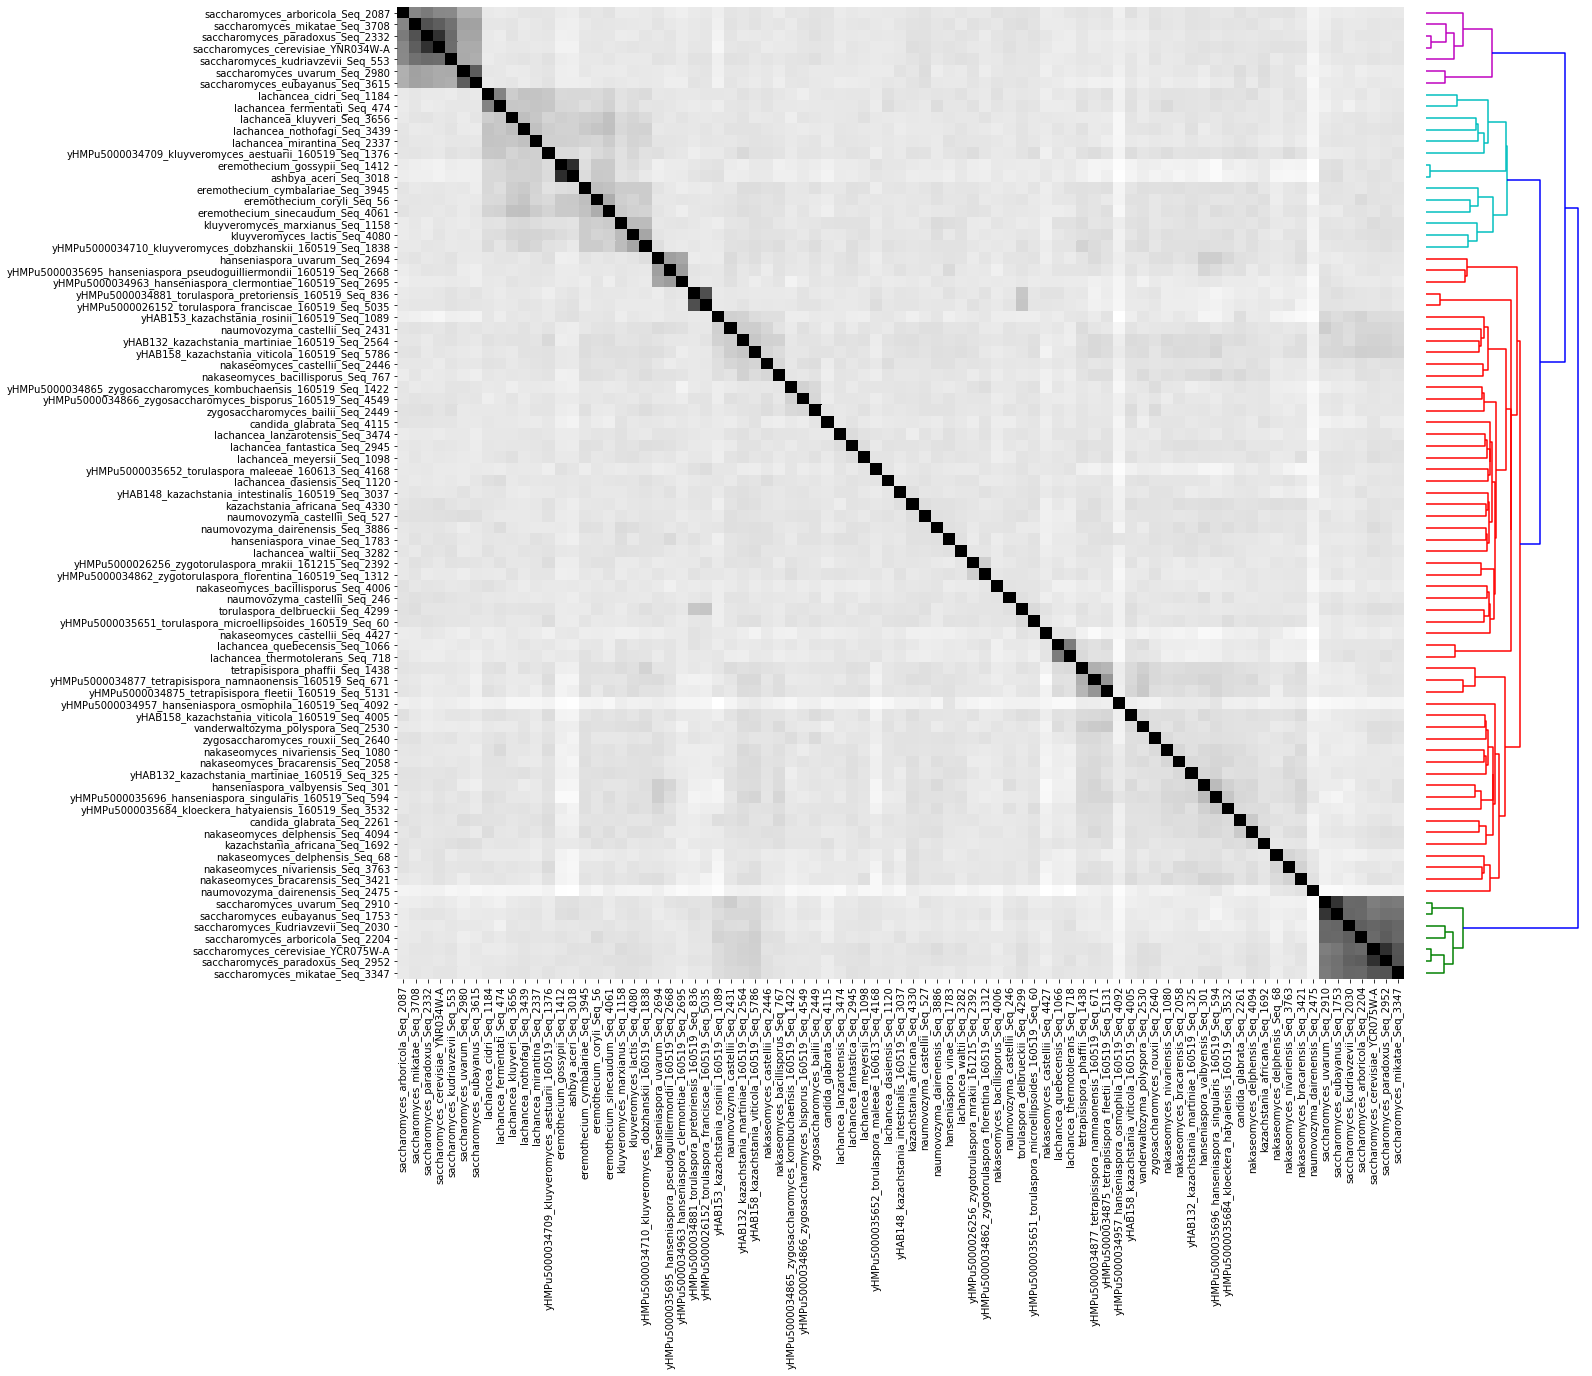

In [56]:
#Performs heirarchical clustering on row data
fig = plt.figure(constrained_layout=True, figsize=(22,19))
gs = fig.add_gridspec(1,2, width_ratios=[19,3] )
#fig_pct, axarr = plt.subplots(1,3, figsize=(10,20), gridspec_kw={'width_ratios': [1, 20,1]})
ax = fig.add_subplot(gs[0,0])
ax_dend = fig.add_subplot(gs[0,1])


# cols_to_cluster = []

# for term in chart_terms['P']: 
#     for level in ['high', 'low']: 
#         cols_to_cluster.append(term + ' ' + level)

# cols_to_cluster.append([])

#chart_df.loc[:,cols_to_cluster].values
#dm = spd.pdist(chart_df, metric = 'euclidean') #'hamming' #yeast_esr_exp.euclidean_nan_filt looked a bit strange.  Maybe because of differing dimensions?



#dm = spd.squareform(np.max(np.max(alignment_scores_df)) - np.array(alignment_scores_df))

#Rescale so that the identity is always 0, and low scores are low values.  
#The rescale is between the min value and the max value (aside from the score for identity) + a percentage so that the identify score is better, 
#but not much better than the other values.  

diag_pct_from_max = 0.05
max_nonself_score = []
min_nonself_score = []
for col in alignment_scores_df.columns:
    col_sorted = sorted(alignment_scores_df.loc[:,col])
    max_nonself_score.append(col_sorted[-2])
    min_nonself_score.append(col_sorted[0])

min_val = min(min_nonself_score)
max_val = max(max_nonself_score) + diag_pct_from_max*(max(max_nonself_score)-min_val)
    
dm = spd.squareform((1-(np.array(alignment_scores_df)-min_val)/(max_val-min_val)).clip(0) )
row_cluster = sch.linkage(dm, method='ward', optimal_ordering=True) #, 'median' optimal_ordering=True)  #'ward'  #might also try 'centroid', 'median', and 'ward'

#Makes clusters using fclust
#row_index = chart_df.index.tolist()

#T = sch.fcluster(row_cluster,5, criterion='maxclust') #1.153)  #11, criterion = 'maxclust')
#cluster_dict = {}
# ohnolog_cluster_dict = {}
# for kk in list(set(T)):
#     cluster = []
#     for jj,cnum in enumerate(T):
#         if cnum==kk:
#             cluster.append(row_index[jj])
#             ohnolog_cluster_dict[row_index[jj]]=cnum
#     cluster_dict[kk] = cluster
# cluster_dict

# #Plots dendrogram using row cluster:
# cmap = plt.get_cmap('tab20')
# cluster_colors = {clust : mpl_colors.to_hex(cmap(jj)) for jj, clust in enumerate(cluster_dict.keys())}

# cluster_color_func = {}

# for ohnolog_pair_key,cluster_no in enumerate(T):
#     cluster_color = cluster_colors[cluster_no]
#     cluster_color_func[ohnolog_pair_key] = cluster_color

# cluster_color_func
    
# # notes:
# # * rows in Z correspond to "inverted U" links that connect clusters
# # * rows are ordered by increasing distance
# # * if the colors of the connected clusters match, use that color for link
# #
# # Based on answer from https://stackoverflow.com/questions/38153829/custom-cluster-colors-of-scipy-dendrogram-in-python-link-color-func

# link_cols = {}
# dflt_col = "#808080"   # Unclustered gray
# for ind, linked_inds in enumerate(row_cluster[:,:2].astype(int)):
#     colors =[]
#     for jj,linked_ind in enumerate(linked_inds): 
#         if linked_ind > len(row_cluster): 
#             colors.append(link_cols[linked_ind])
#         else:
#             colors.append(cluster_color_func[linked_ind])
    
#     assert len(colors)==2 
#     if colors[0]==colors[1]:
#         link_cols[ind+1+len(row_cluster)] = colors[0] 
#     else: 
#         link_cols[ind+1+len(row_cluster)] = dflt_col
        
dendrogram = sch.dendrogram(Z=row_cluster, no_labels=True, orientation='right', ax=ax_dend) #count_sort='ascending',, link_color_func=lambda x: link_cols[x]), ax=ax_clust
ax_dend.set_frame_on(False)
ax_dend.set_xticks([])
# #dn1 = sch.dendrogram(row_cluster, ax=ax_clust, above_threshold_color='y', orientation='left')


#Reorders index to match dendrogram for heatmap
ind_reorder = dendrogram['leaves'].copy()
ind_reorder.reverse()

# #row_ind_reorder = sch.leaves_list(row_cluster)

old_inds = alignment_scores_df.index.tolist()
new_inds = [old_inds[ind] for ind in ind_reorder]

# old_cols = list(alignment_scores_df.columns)
# new_cols = [old_cols[ind] for ind in ind_reorder]

alignment_scores_df_clustered = alignment_scores_df.reindex(new_inds).loc[:,new_inds]


sns.heatmap(alignment_scores_df_clustered, cmap='binary', cbar = False, ax = ax, rasterized=True)

# ymin = 0
# ymax = len(chart_df_clustered)
#ax.set_ylabel('$DE_{PKA}$ ohnolog pairs', {"fontsize": 40})
#ax.vlines([0] + list(np.arange(1, 2*(sum(term_list_len)+2), 2)), ymin=ymin, ymax=ymax, colors = '#d9d9d9', linewidth=1)
#ax.vlines([1] + [1+2*sum(term_list_len[0:jj]) for jj in [1,2]], ymin=ymin, ymax = ymax, colors = 'b', linewidth=5)
#ax.set_xticks([0.5] + list(np.arange(2, 2*(sum(term_list_len)+1), 2)))
#ax.set_xticklabels(term_labels, fontdict={"fontsize":26})

fig.savefig(figsave_dir + 'promoter_pairwise_clust_'+ goi_pair + '.svg') 

<IPython.core.display.Javascript object>


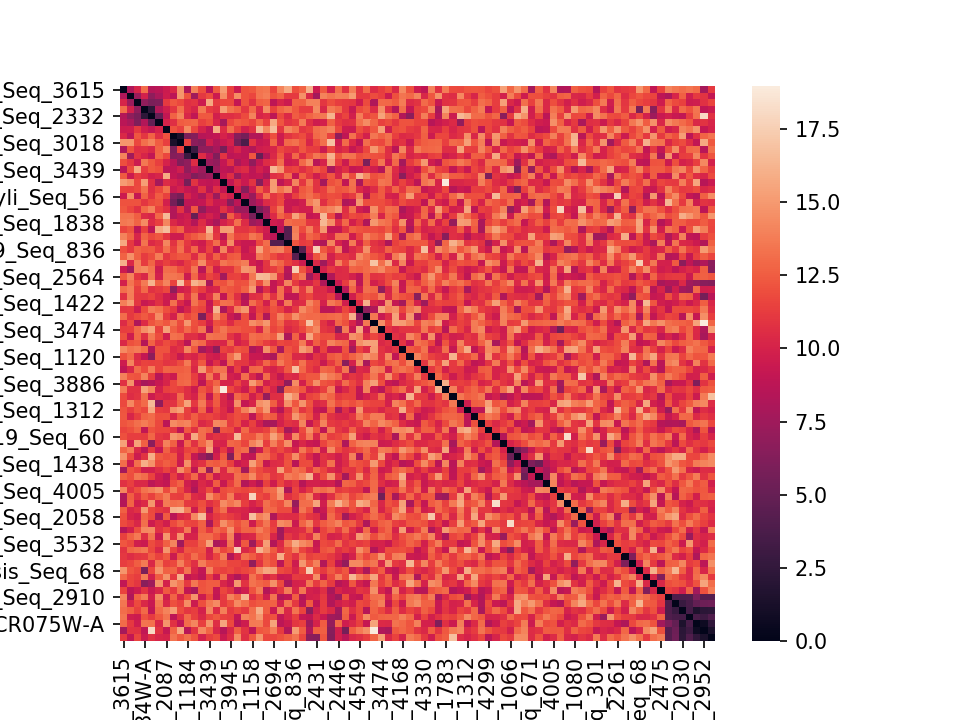

In [152]:
fig, ax = plt.subplots(1,1)
alignment_N_optimal_df_clustered = alignment_N_optimal_df.reindex(new_inds).loc[:,new_inds]
sns.heatmap(alignment_N_optimal_df_clustered, ax=ax)

In [109]:
gene_1_name = 'yHAB132_kazachstania_martiniae_160519_Seq_325' #'saccharomyces_paradoxus_Seq_2332' #'saccharomyces_arboricola_Seq_2087'#'saccharomyces_paradoxus_Seq_2332'
gene_2_name = 'saccharomyces_cerevisiae_YNR034W-A'

gene_1 = prom_seqs_list[spec_gene_lookup[gene_1_name]]
gene_2 = prom_seqs_list[spec_gene_lookup[gene_2_name]]

gene_1_L = int(gene_1.description.split(' ')[-1].split('=')[1])
gene_2_L = int(gene_2.description.split(' ')[-1].split('=')[1])

if gene_1_L != 700: 
    print('Warning: ' + gene_1_name + ' not equal to 700. L=' + str(gene_1_L))
    
if gene_2_L != 700: 
    print('Warning: ' + gene_2_name + ' not equal to 700. L=' + str(gene_2_L))
    
# gene_1_seq = 
# gene_2_seq = 

## Get MSAs for different groups.  

In [3]:
#Load prom_phyls which maps results from manual curation of WGH orthologs
prom_phyls = {}

prom_phyl = {}
prom_phyl_YGOB = {}
#prom_phyl['high'] = ['saccharomyces_cerevisiae_YDL021W', 'saccharomyces_mikatae_Seq_4168', 'saccharomyces_kudriavzevii_Seq_2898', 'saccharomyces_uvarum_Seq_298','candida_glabrata_Seq_689']
prom_phyl['high'] = ['saccharomyces_cerevisiae_YDL021W',
 'nakaseomyces_castellii_Seq_2450',
 'nakaseomyces_bacillisporus_Seq_147',
 'candida_glabrata_Seq_689',
 'nakaseomyces_bracarensis_Seq_1806',
 'nakaseomyces_delphensis_Seq_2587',
 'nakaseomyces_nivariensis_Seq_2262',
 'saccharomyces_eubayanus_Seq_4042',
 'saccharomyces_uvarum_Seq_298',
 'saccharomyces_arboricola_Seq_2168',
 'saccharomyces_kudriavzevii_Seq_2898',
 'saccharomyces_mikatae_Seq_4168',
 'saccharomyces_paradoxus_Seq_4505']


prom_phyl_YGOB['high'] = ['YDL021W', 'Smik_4.214','Skud_4.228','Suva_4.227', 'CAGL0K01705g']

#prom_phyl['low'] = ['saccharomyces_cerevisiae_YOL056W', 'saccharomyces_mikatae_Seq_453', 'saccharomyces_uvarum_Seq_4445', 'kazachstania_africana_Seq_41', 'naumovozyma_castellii_Seq_1503', 'naumovozyma_dairenensis_Seq_3200', 'tetrapisispora_blattae_Seq_2219', 'tetrapisispora_phaffii_Seq_3511', 'vanderwaltozyma_polyspora_Seq_4285']
prom_phyl['low'] = ['saccharomyces_cerevisiae_YOL056W',
 'kazachstania_africana_Seq_41',
 'naumovozyma_castellii_Seq_1503',
 'naumovozyma_dairenensis_Seq_3200',
 'saccharomyces_eubayanus_Seq_4127',
 'saccharomyces_mikatae_Seq_453',
 'saccharomyces_paradoxus_Seq_556',
 'saccharomyces_uvarum_Seq_4445',
 'tetrapisispora_phaffii_Seq_3511',
 'vanderwaltozyma_polyspora_Seq_4285',
 'yHAB132_kazachstania_martiniae_160519_Seq_4635',
 'yHAB133_kazachstania_unispora_160519_Seq_2374',
 'yHAB134_kazachstania_turicensis_160519_Seq_1990',
 'yHAB143_kazachstania_siamensis_160519_Seq_1903',
 'yHAB147_kazachstania_taianensis_160519_Seq_2501',
 'yHAB153_kazachstania_rosinii_160519_Seq_2148',
 'yHAB158_kazachstania_viticola_160519_Seq_4041',
 'yHAB159_kazachstania_solicola_160519_Seq_4608',
 'yHAB164_kazachstania_aerobia_160519_Seq_2028',
 'yHMPu5000034875_tetrapisispora_fleetii_160519_Seq_3577',
 'yHMPu5000034876_tetrapisispora_iriomotensis_160519_Seq_3652',
 'yHMPu5000034877_tetrapisispora_namnaonensis_160519_Seq_4595']

prom_phyl_YGOB['low'] = ['YOL056W', 'Smik_15.103', 'Skud15.97', 'Suva15.109', 'KAFR0C00970', 'KNAG0K01200', 'NCAS0C03650', 'NDAI0G02990', 'TBLA0G00870', 'TPHA0P00600', 'Kpol_1045.50']

prom_phyls['GPM2_GPM3'] = prom_phyl

prom_phyl = {}
prom_phyl_YGOB = {}
#prom_phyl['high'] = ['saccharomyces_cerevisiae_YGR256W',  'saccharomyces_kudriavzevii_Seq_1713', 'saccharomyces_uvarum_Seq_4669', 'kazachstania_africana_Seq_4332', 'kazachstania_naganishii_Seq_4463']

prom_phyl['high'] = ['saccharomyces_cerevisiae_YGR256W',
 'kazachstania_africana_Seq_4332',
 'nakaseomyces_bacillisporus_Seq_4561',
 'saccharomyces_eubayanus_Seq_2030',
 'saccharomyces_uvarum_Seq_4669',
 'saccharomyces_arboricola_Seq_4380',
 'saccharomyces_kudriavzevii_Seq_1713',
 'saccharomyces_paradoxus_Seq_87',
 'yHAB158_kazachstania_viticola_160519_Seq_1107',
 'yHAB153_kazachstania_rosinii_160519_Seq_85',
 'yHAB155_kazachstania_spencerorum_160519_Seq_626',
 'yHAB132_kazachstania_martiniae_160519_Seq_4190',
 'yHAB148_kazachstania_intestinalis_160519_Seq_1326',
 'yHAB136_kazachstania_bromeliacearum_160519_Seq_3141',
 'kazachstania_naganishii_Seq_4463',
 'yHAB147_kazachstania_taianensis_160519_Seq_3956',
 'yHAB166_kazachstania_yakushimaensis_160519_Seq_4162',
 'yHAB154_kazachstania_transvaalensis_160519_Seq_432',
 'yHAB143_kazachstania_siamensis_160519_Seq_5064',
 'yHAB133_kazachstania_unispora_160519_Seq_1356',
 'yHAB164_kazachstania_aerobia_160519_Seq_1036',
 'yHAB159_kazachstania_solicola_160519_Seq_680']

prom_phyl_YGOB['high'] = ['YGR256W', 'Skud_7.590','Suva_7.554', 'KAFR0B04490', 'KNAG0K00390']

#prom_phyl['low'] = ['saccharomyces_cerevisiae_YHR183W', 'saccharomyces_mikatae_Seq_4845', 'saccharomyces_uvarum_Seq_4794', 'saccharomyces_kudriavzevii_Seq_185', 'candida_glabrata_Seq_5136', 'kazachstania_africana_Seq_551', 'naumovozyma_castellii_Seq_43', 'naumovozyma_dairenensis_Seq_164', 'tetrapisispora_blattae_Seq_92']
prom_phyl['low'] = ['saccharomyces_cerevisiae_YHR183W',
 'candida_glabrata_Seq_5136',
 'naumovozyma_castellii_Seq_43',
 'tetrapisispora_blattae_Seq_92',
 'yHMPu5000035629_yueomyces_sinensis_160519_Seq_977',
 'nakaseomyces_castellii_Seq_4652',
 'nakaseomyces_bacillisporus_Seq_1423',
 'nakaseomyces_bracarensis_Seq_1690',
 'nakaseomyces_delphensis_Seq_1403',
 'nakaseomyces_nivariensis_Seq_5143',
 'saccharomyces_eubayanus_Seq_879',
 'saccharomyces_uvarum_Seq_4794',
 'saccharomyces_arboricola_Seq_3052',
 'saccharomyces_kudriavzevii_Seq_185',
 'saccharomyces_mikatae_Seq_4845',
 'saccharomyces_paradoxus_Seq_2121',
 'naumovozyma_dairenensis_Seq_164',
 'yHAB158_kazachstania_viticola_160519_Seq_1939',
 'kazachstania_africana_Seq_551',
 'yHAB153_kazachstania_rosinii_160519_Seq_895',
 'yHAB155_kazachstania_spencerorum_160519_Seq_5608',
 'yHAB160_kazachstania_kunashirensis_160519_Seq_407',
 'yHAB134_kazachstania_turicensis_160519_Seq_2234',
 'yHAB148_kazachstania_intestinalis_160519_Seq_3782']

prom_phyl_YGOB['low'] = ['YHR183W', 'Smik_8.271', 'Skud_8.246', 'Suva_15.384', 'CAGL0M13343g','KAFR0B1610',  'NCAS0F02030', 'NDAI0C03490',  
'TBLA0C06670']
prom_phyls['GND2_GND1'] = prom_phyl


prom_phyl = {}
prom_phyl_YGOB = {}
prom_phyl['high'] = [
 'yHAB132_kazachstania_martiniae_160519_Seq_325',
 'yHAB158_kazachstania_viticola_160519_Seq_4005',
 'kazachstania_africana_Seq_4330',
 'yHAB148_kazachstania_intestinalis_160519_Seq_3037',
 'naumovozyma_castellii_Seq_246',
 'naumovozyma_castellii_Seq_527',
 'naumovozyma_dairenensis_Seq_2475',                    
 'nakaseomyces_bacillisporus_Seq_4006',
 'nakaseomyces_castellii_Seq_4427',
 'nakaseomyces_delphensis_Seq_68',
 'candida_glabrata_Seq_4115',
 'nakaseomyces_bracarensis_Seq_3421',
 'nakaseomyces_nivariensis_Seq_3763',
 'saccharomyces_arboricola_Seq_2087',
 'saccharomyces_kudriavzevii_Seq_553',
 'saccharomyces_mikatae_Seq_3708',
 'saccharomyces_paradoxus_Seq_2332',
 'saccharomyces_cerevisiae_YNR034W-A',
 'saccharomyces_uvarum_Seq_2980',
 'saccharomyces_eubayanus_Seq_3615']

prom_phyl_YGOB['high'] = ['YNR034W-A', 'Smik_14.365', 'Skud_14.367','Suva_14.390','CAGL0M11000g', 'KAFR0C04650', 'NCAS0A05440', 'NDAI0K02270', 'TBLA0F04160', 'TPHA0M01880']

prom_phyl['low'] = [
 #'vanderwaltozyma_polyspora_Seq_2530',
 #'tetrapisispora_phaffii_Seq_1438',
 #'yHMPu5000034875_tetrapisispora_fleetii_160519_Seq_5131',
 #'yHMPu5000034877_tetrapisispora_namnaonensis_160519_Seq_671',
 'nakaseomyces_bacillisporus_Seq_767', 
 'nakaseomyces_castellii_Seq_2446',
 'candida_glabrata_Seq_2261',
 'nakaseomyces_bracarensis_Seq_2058',
 'nakaseomyces_delphensis_Seq_4094',
 'nakaseomyces_nivariensis_Seq_1080',
 'yHAB132_kazachstania_martiniae_160519_Seq_2564',
 'yHAB153_kazachstania_rosinii_160519_Seq_1089',
 'yHAB158_kazachstania_viticola_160519_Seq_5786',
 'kazachstania_africana_Seq_1692',
 'naumovozyma_castellii_Seq_2431',
 'naumovozyma_dairenensis_Seq_3886',
 'saccharomyces_uvarum_Seq_2910',
 'saccharomyces_eubayanus_Seq_1753',
 'saccharomyces_arboricola_Seq_2204',
 'saccharomyces_kudriavzevii_Seq_2030',
 'saccharomyces_mikatae_Seq_3347',
 'saccharomyces_paradoxus_Seq_2952',
 'saccharomyces_cerevisiae_YCR075W-A']

prom_phyl['ZT'] = ['zygosaccharomyces_rouxii_Seq_2640', 
                   'yHMPu5000034865_zygosaccharomyces_kombuchaensis_160519_Seq_1422', 
                   'yHMPu5000034866_zygosaccharomyces_bisporus_160519_Seq_4549', 
                   'zygosaccharomyces_bailii_Seq_2449',
                   'yHMPu5000035651_torulaspora_microellipsoides_160519_Seq_60', 
                   'yHMPu5000035652_torulaspora_maleeae_160613_Seq_4168', 
                   'torulaspora_delbrueckii_Seq_4299', 
                   'yHMPu5000026152_torulaspora_franciscae_160519_Seq_5035', 
                   'yHMPu5000034881_torulaspora_pretoriensis_160519_Seq_836', 
                   'yHMPu5000026256_zygotorulaspora_mrakii_161215_Seq_2392', 
                   'yHMPu5000034862_zygotorulaspora_florentina_160519_Seq_1312'
                  ]

prom_phyl['KLE'] = ['lachancea_mirantina_Seq_2337', 
                    'lachancea_kluyveri_Seq_3656',
                    'lachancea_fermentati_Seq_474', 
                    'lachancea_cidri_Seq_1184',
                    'yHMPu5000034709_kluyveromyces_aestuarii_160519_Seq_1376', 
                    'kluyveromyces_marxianus_Seq_1158',
                    'yHMPu5000034710_kluyveromyces_dobzhanskii_160519_Seq_1838',
                    'kluyveromyces_lactis_Seq_4080', 
                    'eremothecium_sinecaudum_Seq_4061',
                    'eremothecium_cymbalariae_Seq_3945',
                    'eremothecium_coryli_Seq_56',
                    'eremothecium_gossypii_Seq_1412', 
                    'lachancea_waltii_Seq_3282', 
                    'lachancea_dasiensis_Seq_1120', 
                    'lachancea_nothofagi_Seq_3439', 
                    'lachancea_quebecensis_Seq_1066', 
                    'lachancea_thermotolerans_Seq_718', 
                    'lachancea_meyersii_Seq_1098', 
                    'lachancea_fantastica_Seq_2945', 
                    'lachancea_lanzarotensis_Seq_3474'
                   ]

prom_phyl_YGOB['low'] = ['YCR075W-A', 'Smik_3.176', 'Skud_3.149', 'Suva_3.113', 'CAGL0M07001g','KAFR0F04310', 'KNAG0I02790', 'NCAS0D04640', 'NDAI0I00320',  
'Kpol_1028.35']
prom_phyls['EGO4_EGO2'] = prom_phyl

In [13]:
#select promoters from different groups and save them

goi_pair = 'EGO4_EGO2'
goi_alignments = {'EGO4_EGO2': 'OG6958_OG10444_OG38595_EGO4_EGO2', 
                  'GPM2_GPM3': 'OG6005_GPM2_GPM3'}

groups = ['KLE', 'low','ZT','high']

occ_thresh = 9/19 #percentage of sequences in which something must be present in the alignment
                  #There are 7 of 19 in the low group that are in the saccharomyces clade so we want at least two more from other groups to call a conserved block
                  

#Alternative could be to tailor each one, but seems safe to keep it the same for all
# {'low': 9/19, 
#  'high': 9/20, 
#  'KLE': 9/19, 
#  'ZT': 9/19} 9/19  


min_len = 8 #Minimum length for a block of conserved sequences
max_gap = 3 #Maximum gap between blocks of conserved sequences

motif_max_pval = 0.001  

#Tried q-value threshold of 10%, but that didn't pick up STREs. 
#STRE q-value changes based on the length of the region, so just used p-value which seams steady at 0.000709 for an STRE.  

y1000_plus_dir_ubuntu = '/mnt/c' +  "/".join(y1000plus_dir.split(':')[1].split('\\'))


In [139]:



#Load all Fastas and make lookup table
prom_fname = y1000plus_dir + os.path.normpath('promoter_sets/' + goi_alignments[goi_pair] + '.fasta')
#prom_fname = y1000plus_dir + os.path.normpath('promoter_sets/OG6005_GPM2_GPM3.fasta')

prom_seqs = SeqIO.parse(prom_fname, "fasta")  

prom_seqs_list = list(prom_seqs)

spec_gene_lookup = {}
spec_gene_list = []
for jj, prom_seq in enumerate(prom_seqs_list): 
    spec = prom_seq.description.split(' ')[0].split('=')[1]
    gene = prom_seq.description.split(' ')[2].split('=')[1]
    spec_gene = spec + '_' + gene
    spec_gene_list.append(spec_gene)
    spec_gene_lookup[spec_gene] = jj



In [6]:
#Save subsets as separate files

for group_name in groups:
    spec_list = prom_phyls[goi_pair][group_name]
    group_fasta_fname = y1000plus_dir + os.path.normpath('promoter_sets/prom_conservation/' + goi_pair + '/' + group_name + '/' + goi_alignments[goi_pair] + '_' + group_name + '.fasta')
    with open(group_fasta_fname, 'w') as f_out: 
        for spec in spec_list: 
            prom_seq = prom_seqs_list[spec_gene_lookup[spec]]
            f_out.write('>' + spec + '\n')
            f_out.write(str(prom_seq.seq) + '\n')        



In [23]:
#Get alignments with Mafft.  This prints the commands.  Run them in WSL individually

for group_name in groups: 
    prom_fname_base_ubuntu = '/mnt/c' +  "/".join(y1000plus_dir.split(':')[1].split('\\')) + 'promoter_sets/prom_conservation/' + goi_pair + '/' + group_name + '/' + goi_alignments[goi_pair] + '_' + group_name

    #Mafft command
    #This is the E-ENS-i algorithm which is suitable for conserved regions separated by long unaligned gaps. https://mafft.cbrc.jp/alignment/software/algorithms/algorithms.html

    #Mafft 7.310-1
    mafft_command = ['mafft', '--genafpair', '--maxiterate', '1000', 
                    prom_fname_base_ubuntu + '.fasta', 
                    '>',
                    prom_fname_base_ubuntu + '_aln.fasta']

    print(' '.join(mafft_command))
    
    #Couldn't run mafft from notebook - permission error.  Could run it from Windows shell.  Just printing out the commands and running individually
    
#     sub_out = subprocess.run('bash.exe -c "' + ' '.join(mafft_command) + '"', shell=True)
#     assert sub_out==0, 'Mafft call unsuccessful, ' + goi_pair + ' ' + group_name 


mafft --genafpair --maxiterate 1000 /mnt/c/Users/BMH_work/github/y1000plus_tools/genomes/y1000plus/promoter_sets/prom_conservation/EGO4_EGO2/KLE/OG6958_OG10444_OG38595_EGO4_EGO2_KLE.fasta > /mnt/c/Users/BMH_work/github/y1000plus_tools/genomes/y1000plus/promoter_sets/prom_conservation/EGO4_EGO2/KLE/OG6958_OG10444_OG38595_EGO4_EGO2_KLE_aln.fasta
mafft --genafpair --maxiterate 1000 /mnt/c/Users/BMH_work/github/y1000plus_tools/genomes/y1000plus/promoter_sets/prom_conservation/EGO4_EGO2/low/OG6958_OG10444_OG38595_EGO4_EGO2_low.fasta > /mnt/c/Users/BMH_work/github/y1000plus_tools/genomes/y1000plus/promoter_sets/prom_conservation/EGO4_EGO2/low/OG6958_OG10444_OG38595_EGO4_EGO2_low_aln.fasta
mafft --genafpair --maxiterate 1000 /mnt/c/Users/BMH_work/github/y1000plus_tools/genomes/y1000plus/promoter_sets/prom_conservation/EGO4_EGO2/ZT/OG6958_OG10444_OG38595_EGO4_EGO2_ZT.fasta > /mnt/c/Users/BMH_work/github/y1000plus_tools/genomes/y1000plus/promoter_sets/prom_conservation/EGO4_EGO2/ZT/OG6958_OG104

In [14]:
#read in alignment, calculate occupancy, and use occupancy threshold to trim alignment

#extract sequences for all those alignments, and scan for motifs
#Note: manually added STRE and TATA motifs to motif file,
#Removed the following motifs which are redundant with the STRE: 
#  MSN2, MSN4, USV1, GIS1, YER130C, RPH1
#
#Removed the following motifs which are redundant with the TATA: 
#PHO2,  NCU00019, MOT2.  Kept SUM1 and YOX1 which are a bit different.  
#
#Removed Mig2 and Mig3 which are redundant with Mig1

motif_dfs = {}
blocks_to_keep_dict = {}

rerun_fimo=True

if rerun_fimo: 
    block_name_lists = {}

for group_name in groups: 
    print(group_name)
    #Read in alignment
    prom_fname_group = y1000plus_dir + os.path.normpath('promoter_sets/prom_conservation/' + goi_pair + '/' + group_name + '/' + goi_alignments[goi_pair] + '_' + group_name + '_aln.fasta')
    prom_msa = AlignIO.read(prom_fname_group, 'fasta')
    prom_msa_array = np.array([list(rec) for rec in prom_msa], np.character, order="F")
    
    #calculate occupancy
    blocks_to_keep = occupancy_find_filter(prom_msa_array, occ_thresh=occ_thresh, min_len=min_len, max_gap=max_gap)
    blocks_to_keep_dict[group_name] = blocks_to_keep
    
    fimo_fname_base = y1000plus_dir + os.path.normpath('promoter_sets/prom_conservation/' + goi_pair + '/' + group_name) + os.sep
    fimo_fname_base_ubuntu = y1000_plus_dir_ubuntu + 'promoter_sets/prom_conservation/' + goi_pair + '/'+ group_name + '/'
    motif_fname = '/mnt/c/Users/BMH_work/github/yeast_esr_expression_analysis/expression_data/motifs/JASPAR2018_CORE_fungi_non-redundant_pfms_meme_STRE_TATA.meme'
    
    if rerun_fimo: 
        #would be good to break this into two functions - one to run fimo and one to build the df
        block_name_list = find_motifs_in_blocks(blocks_to_keep, prom_msa, motif_max_pval, fimo_fname_base, fimo_fname_base_ubuntu, motif_fname)
        block_name_lists[group_name] = block_name_list
    
    motif_dfs_group = read_fimo_data(block_name_lists[group_name], prom_msa_array, fimo_fname_base)
    motif_dfs[group_name] = motif_dfs_group
    


KLE
174_315
328_379
406_440
476_498
512_546
577_624
629_650
701_710
719_762
771_782
854_938
972_1026
1055_1074
1088_1119
1153_1170
1222_1260
fasta files and fimo run on blocks, saved in C:\Users\BMH_work\github\y1000plus_tools\genomes\y1000plus\promoter_sets\prom_conservation\EGO4_EGO2\KLE\
low
32_58
68_82
92_210
218_341
373_385
470_516
524_562
571_584
594_693
769_792
919_949
1043_1061
1082_1099
1107_1116
1172_1202
1232_1253
1295_1340
fasta files and fimo run on blocks, saved in C:\Users\BMH_work\github\y1000plus_tools\genomes\y1000plus\promoter_sets\prom_conservation\EGO4_EGO2\low\
ZT
30_66
71_91
122_148
158_189
217_259
265_278
285_337
384_396
410_452
465_476
499_509
515_565
570_598
660_669
691_702
712_780
790_844
858_914
922_941
980_999
1018_1043
1064_1121
fasta files and fimo run on blocks, saved in C:\Users\BMH_work\github\y1000plus_tools\genomes\y1000plus\promoter_sets\prom_conservation\EGO4_EGO2\ZT\
high
99_136
274_299
385_399
409_438
453_477
489_508
543_577
583_611
621_633
655_6

In [33]:
#Build visualization dataframe

min_specs_w_motif = 3 #Minimum number of species with the motif in a block to visualize
cm_custom = colors.ListedColormap(["white", "b", "r", "black"])

motif_dfs_vis = {}
N_motifs_to_view = {}

block_name_lists_vis = {}

for group_name in groups: 
        
    motif_dfs_vis_group = {}
    N_motifs_to_view_group = []
    block_name_lists_vis_group = []
    
    for block_name in block_name_lists[group_name]: 
        motif_df = motif_dfs[group_name][block_name]
        motif_df_filt = motif_df.loc[:, (motif_df>0).sum()>=min_specs_w_motif]

        #only visualize indicator not number
        motif_df_filt_ind = (motif_df_filt>0).astype(int)
        if 'TATA' in motif_df_filt_ind.columns:
            motif_df_filt_ind['TATA'] = motif_df_filt_ind['TATA']*0.25

        if 'STRE' in motif_df_filt_ind.columns:
            motif_df_filt_ind['STRE'] = motif_df_filt_ind['STRE']*0.74


        if motif_df_filt_ind.shape[1]==0:
            print( group_name + ' block ' + block_name + ' has no motifs')
        else:
            block_name_lists_vis_group.append(block_name)
            motif_dfs_vis_group[block_name] = motif_df_filt_ind
            N_motifs_to_view_group.append(len(motif_df_filt_ind.columns))
    
    motif_dfs_vis[group_name] = motif_dfs_vis_group
    N_motifs_to_view[group_name] = N_motifs_to_view_group
    block_name_lists_vis[group_name] = block_name_lists_vis_group

    #sns.heatmap(motif_df_filt)

KLE block 476_498 has no motifs
KLE block 701_710 has no motifs
KLE block 1153_1170 has no motifs
low block 769_792 has no motifs
low block 1107_1116 has no motifs
ZT block 71_91 has no motifs
ZT block 122_148 has no motifs
ZT block 265_278 has no motifs
ZT block 384_396 has no motifs
ZT block 465_476 has no motifs
ZT block 499_509 has no motifs
ZT block 660_669 has no motifs
ZT block 691_702 has no motifs
high block 385_399 has no motifs
high block 621_633 has no motifs
high block 1328_1341 has no motifs


In [36]:
motif_dfs_vis['ZT']['980_999']

,TATA
0,0.00
1,0.25
2,0.25
3,0.25
4,0.25
5,0.00
6,0.25
7,0.00
8,0.00
9,0.25


In [34]:
N_motifs_to_view

{'KLE': [93, 16, 7, 4, 17, 7, 23, 2, 45, 2, 3, 4, 9],
 'low': [3, 1, 41, 77, 1, 14, 21, 6, 53, 1, 4, 10, 12, 3, 11],
 'ZT': [3, 1, 1, 7, 8, 4, 2, 18, 9, 3, 2, 1, 1, 8],
 'high': [8, 1, 11, 2, 1, 4, 7, 12, 5, 5, 1, 5, 28, 19, 20, 7, 15, 6, 4, 5, 1]}

In [156]:

# columns = [field.split('=')[0] for field in motif_table.loc[0,'sequence_name'].split('__')]
# col_rename = {'strand':'chr_strand', 'start':'chr_strand', 'end':'chr_strand'}
# columns_new = []
# for col in columns:
#     if col in col_rename.keys():
#         columns_new.append(col_rename[col])
#     else: 
#         columns_new.append(col)
# columns_new

     

# field_cols = {}
# for ind, row in motif_table.iterrows():
#     seq_full = row['sequence_name'].split('__')
#     field_cols[ind]=tuple((field.split('=')[1] for field in seq_full))

# metadata = pd.DataFrame.from_dict(field_cols, columns=columns_new, orient='index')
# motif_table = pd.concat([motif_table, metadata], axis = 1)
# motif_table.drop('sequence_name', axis=1, inplace=True)

# motif_table

# motif_table_multind = motif_table.set_index(['sequence_name', 'motif_alt_id'])
# motif_table_multind.sort_index(inplace=True)



In [24]:
block_name_lists_vis

{'KLE': ['174_315',
  '328_379',
  '406_440',
  '476_498',
  '512_546',
  '577_624',
  '629_650',
  '719_762',
  '771_782',
  '854_938',
  '972_1026',
  '1055_1074',
  '1088_1119',
  '1153_1170',
  '1222_1260'],
 'low': ['32_58',
  '68_82',
  '92_210',
  '218_341',
  '373_385',
  '470_516',
  '524_562',
  '571_584',
  '594_693',
  '769_792',
  '919_949',
  '1043_1061',
  '1082_1099',
  '1172_1202',
  '1232_1253',
  '1295_1340'],
 'ZT': ['30_66',
  '122_148',
  '158_189',
  '217_259',
  '285_337',
  '384_396',
  '410_452',
  '499_509',
  '515_565',
  '570_598',
  '691_702',
  '712_780',
  '790_844',
  '858_914',
  '922_941',
  '980_999',
  '1018_1043',
  '1064_1121'],
 'high': ['99_136',
  '274_299',
  '385_399',
  '409_438',
  '453_477',
  '489_508',
  '543_577',
  '583_611',
  '621_633',
  '655_680',
  '685_698',
  '704_714',
  '745_761',
  '814_857',
  '937_1004',
  '1021_1060',
  '1104_1148',
  '1164_1189',
  '1238_1275',
  '1328_1341',
  '1362_1388',
  '1393_1420',
  '1436_1460',
 

21
[8, 1, 11, 2, 1, 4, 7, 12, 5, 5, 1, 5, 28, 19, 20, 7, 15, 6, 4, 5, 1]
99_136
274_299
409_438
453_477
489_508
543_577
583_611
655_680
685_698
704_714
745_761
814_857
937_1004
1021_1060
1104_1148
1164_1189
1238_1275
1362_1388
1393_1420
1436_1460
1473_1488


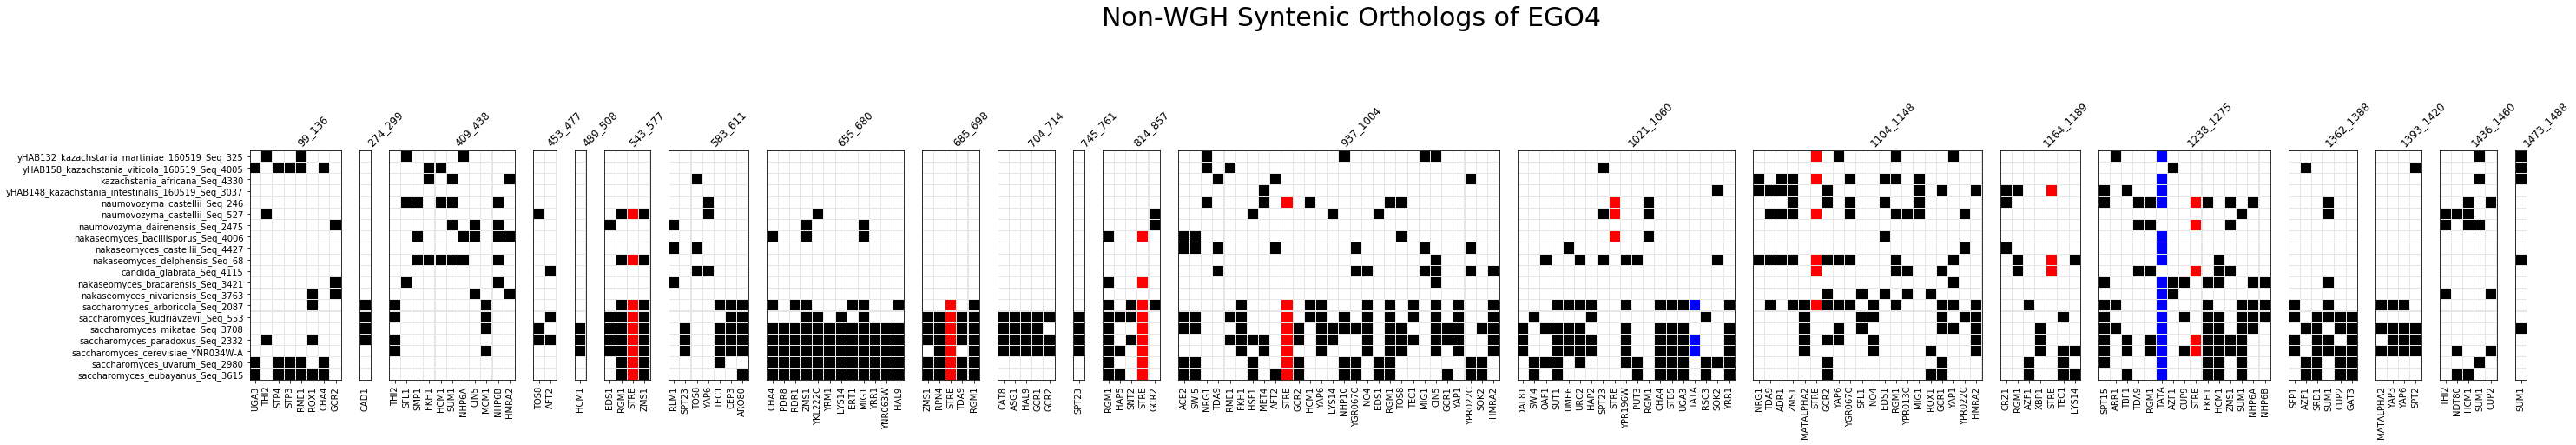

In [58]:
group_name = 'high'

labels = {'low': 'Non-WGH Syntenic Orthologs of EGO2', 
          'high': 'Non-WGH Syntenic Orthologs of EGO4',
          'KLE': 'KLE orthologs of EGO2/4', 
          'ZT': 'ZT orthologs of EGO2/4'}

#ylabel_len = 0

tot_motifs = sum(N_motifs_to_view[group_name])
fig = plt.figure(figsize=(np.floor(tot_motifs/3.5),len(block_name_lists_vis[group_name]))) #, tight_layout=True) # constrained_layout=True, , tight_layout(rect=[0, 0.03, 1, 0.9]))

#width_ratios = [ylabel_len + N_motifs_to_view[group_name][0]] + N_motifs_to_view[group_name][1:]
print(len(N_motifs_to_view[group_name]))
print(N_motifs_to_view[group_name])
gs = fig.add_gridspec(1,len(N_motifs_to_view[group_name]), width_ratios=N_motifs_to_view[group_name] )

#sns.set_style("white", {'axes.linewidth': 5, 'grid.color': 'black'}) #, 'xtick.major.size': 10, 'ytick.major.size': 0})

for jj, block_name in enumerate(block_name_lists_vis[group_name]): 
    #fig_pct, axarr = plt.subplots(1,3, figsize=(10,20), gridspec_kw={'width_ratios': [1, 20,1]})
    ax = fig.add_subplot(gs[0,jj])
    print(block_name)
    vis_data = motif_dfs_vis[group_name][block_name]
    if jj==0:
        specnames = prom_phyls[goi_pair][group_name]
        sns.heatmap(vis_data, cbar=False, cmap = cm_custom, xticklabels=list(vis_data.columns), yticklabels=specnames,  square='True', linewidths=0.1, linecolor= [0.9, 0.9, 0.9] , ax=ax,vmin=0.0, vmax=1.0)
    else: 
        sns.heatmap(vis_data, cbar=False, cmap = cm_custom, xticklabels=list(vis_data.columns), yticklabels=False,  square='True', linewidths=0.1, linecolor= [0.9, 0.9, 0.9] , ax=ax, edgecolors=[0,0, 0],vmin=0.0, vmax=1.0)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(axis='x',labelrotation=90)
    ax.set_title(block_name, fontdict={'rotation':45, 'ha': 'left'})
    
fig.suptitle(labels[group_name], fontsize=30, y=0.7) #not sure why suptitle has to be lowered so much

fig.savefig(figsave_dir + 'conserved_motifs_' + goi_pair + '_' + group_name +'.svg')


In [48]:
ax.set_title?

In [26]:
block_name_lists_vis[group_name]

['32_58',
 '68_82',
 '92_210',
 '218_341',
 '373_385',
 '470_516',
 '524_562',
 '571_584',
 '594_693',
 '769_792',
 '919_949',
 '1043_1061',
 '1082_1099',
 '1172_1202',
 '1232_1253',
 '1295_1340']

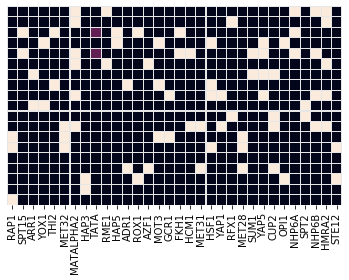

In [23]:
fig,ax = plt.subplots()
sns.heatmap(motif_dfs_vis[group_name][block_name], cbar=False, yticklabels=False,  square='True', linewidths=0.1, linecolor= [0.9, 0.9, 0.9] , ax=ax, edgecolors=[0,0, 0])

In [136]:
fimo -oc /mnt/c/Users/BMH_work/github/y1000plus_tools/genomes/y1000plus/promoter_sets/prom_conservation/EGO4_EGO2/ZT/fimo --thresh 0.001 /mnt/c/Users/BMH_work/github/yeast_esr_expression_analysis/expression_data/motifs/JASPAR2018_CORE_fungi_non-redundant_pfms_meme_STRE_TATA.meme /mnt/c/Users/BMH_work/github/y1000plus_tools/genomes/y1000plus/promoter_sets/prom_conservation/EGO4_EGO2/ZT/block_712_780.fasta

SyntaxError: invalid syntax (<ipython-input-136-4cc7862071e8>, line 1)

In [ ]:
fimo -oc /mnt/c/Users/BMH_work/github/y1000plus_tools/genomes/y1000plus/promoter_sets/prom_conservation/EGO4_EGO2/high/fimo --thresh 0.001 /mnt/c/Users/BMH_work/github/yeast_esr_expression_analysis/expression_data/motifs/JASPAR2018_CORE_fungi_non-redundant_pfms_meme_STRE_TATA.meme /mnt/c/Users/BMH_work/github/y1000plus_tools/genomes/y1000plus/promoter_sets/prom_conservation/EGO4_EGO2/high/block_937_1004.fasta

In [ ]:
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black', 'xtick.major.size': 10, 'ytick.major.size': 0})

In [64]:
motif_dfs_vis[group_name][block_name]

""
0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


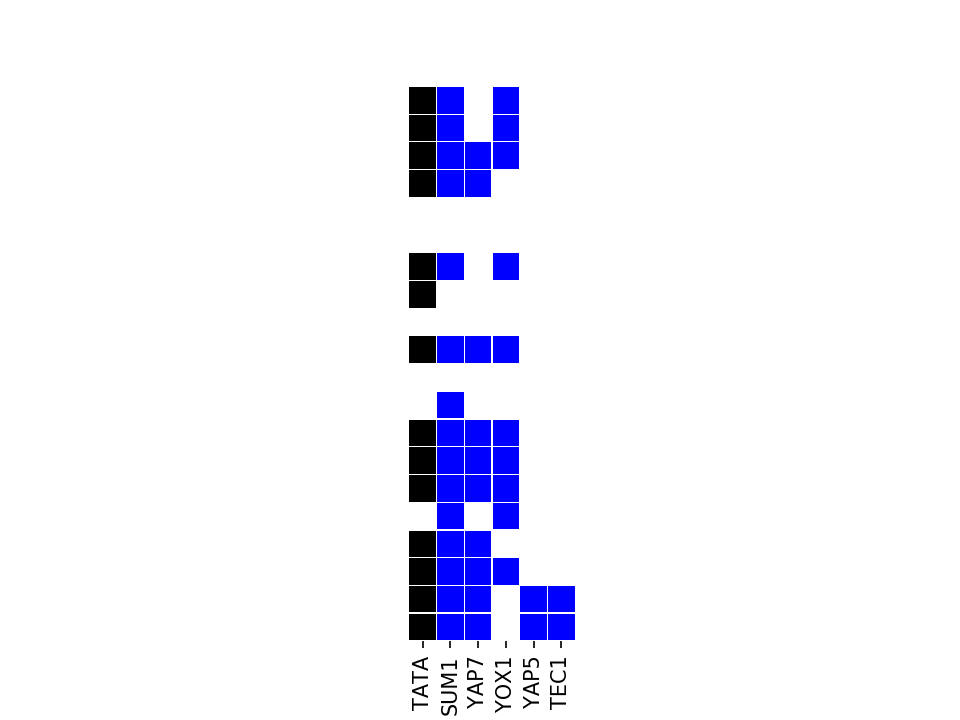

In [96]:
fig,ax = plt.subplots()
sns.heatmap(motif_df_filt_ind, cbar=False, yticklabels=False, cmap=cm_custom, square='True', linewidths=0.1, ax=ax)


In [66]:
binary = cm.get_cmap('binary', 4)

In [71]:
binary(0)
binary(1)
binary(2)
binary(3)

(0.0, 0.0, 0.0, 1.0)

In [167]:
#plt.plot(np.array(occupancy)>occ_thresh)

In [78]:
cm_custom(3)

(0.0, 0.0, 1.0, 1.0)

In [20]:
occupancy[0:-1]+occupancy[1:]

array([0.4 , 0.4 , 0.3 , ..., 0.15, 0.25, 0.3 ])

In [ ]:
def occupancy(msa): 
    
    
    Counter(col)['-']

In [ ]:
#Look for motifs in conserved bits

In [ ]:
#compare motifs in conserved bits

In [63]:
#Get summary dataframe for blocks based on fimo input


fimo_fname_base = y1000plus_dir + os.path.normpath('promoter_sets/prom_conservation/' + goi_pair + '/' + group_name) + os.sep

fimo_fname_base_ubuntu = y1000_plus_dir_ubuntu + 'promoter_sets/prom_conservation/' + goi_pair + '/'+ group_name + '/'


motif_dfs = {}
block_name_list = []

for block in blocks_to_keep: 
    #block = blocks_to_keep[13]
    block_name = str(block[0]) + '_' + str(block[1])
    block_name_list.append(block_name)
    print(block_name)

    #Build fasta for block
    fimo_fname_fasta = fimo_fname_base + 'block_' + block_name + '.fasta'
    with open(fimo_fname_fasta + '','w') as f_fasta:
        for jj, seq in enumerate(prom_msa[:,block[0]:block[1]]):
            seq_str = str(seq.seq)
            seq_str_clean = ''.join([base for base in seq_str if base!='-'])
            if len(seq_str_clean)>0:
                f_fasta.write('>'+str(jj) + '\n')
                f_fasta.write(seq_str_clean + '\n')


    #Find motifs in each conserved block using fimo
    fimo_call = ['/home/heineike/meme/bin/fimo -oc', 
                 fimo_fname_base_ubuntu + 'fimo',          #_block_' + str(block[0]) + '_' + str(block[1]), 
                 '--qv-thresh --thresh ', str(motif_max_qval),
                 '/mnt/c/Users/BMH_work/github/yeast_esr_expression_analysis/expression_data/motifs/JASPAR2018_CORE_fungi_non-redundant_pfms_meme_STRE_TATA.meme',
                 fimo_fname_base_ubuntu + 'block_' + block_name + '.fasta'
                ]

    sub_out = subprocess.call('bash.exe -c "' + ' '.join(fimo_call) + '"')

    assert sub_out==0, 'Fimo call unsuccessful, ' + goi_pair + ' ' + group_name + ' ' + 'block ' + block_name

    #copy .tsv file to home directory, remove extra files
    fimo_out_fname = fimo_fname_base + 'fimo_' + block_name + '.tsv'
    shutil.move(fimo_fname_base + 'fimo/fimo.tsv', fimo_out_fname)
    shutil.rmtree(fimo_fname_base + 'fimo')

    #build dataframe of motif hits
    motif_table = pd.read_table(fimo_out_fname, engine= 'python', skipfooter=4)


    motifs = list(set(motif_table['motif_alt_id']))
    seq_ids = list(range(0,len(prom_msa_array))) #list(set(motif_table['sequence_name']))
    motif_array = {seq_id: {motif: 0 for motif in motifs} for seq_id in seq_ids}

    for seq_id in seq_ids: 
        for motif in motifs: 
            N_hits = len(motif_table[(motif_table['sequence_name']==seq_id) & (motif_table['motif_alt_id']==motif)])
            if N_hits>0:
                motif_array[seq_id][motif] = N_hits

    motif_df = pd.DataFrame.from_dict(motif_array).T

    motif_dfs[block_name] = motif_df

92_136
274_299
382_399
409_438
444_477
489_508
532_577
583_611
621_633
652_698
704_716
745_761
814_857
937_1004
1021_1060
1104_1149
1164_1189
1238_1279
1291_1308
1321_1351
1362_1388
1393_1423
1435_1465
1473_1488
